# Simulations

This notebook will simulate the behaviour of a decision algorithm, which will decide when to charge and discharge a battery.

It will be presented at least three algorithms:

1. Baseline
    - No batteries in this scenario
2. Baseline with batteries
    - The same as the baseline, but the CER will have batteries
3. Baseline with batteries and AI/ML
    - The final algorithm will use AI/ML to make a decision on the next action.

Furthermore, there must be scenarios to run these algorithms, with low/high production and low/high battery capacity.

Aditional scenarios and algorithms may or may not be added in the future.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import xgboost as xgb

import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
TARIFA_SIMPLES = 0.1583
TARIFA_PONTA = 0.1917
TARIFA_FORA_PONTA = 0.1044

## Pre-Processing

In this section, the data will be pre-processed, using the pre-trained ML model, merging prices and weather data.

In [3]:
energy_df = pd.read_csv("../data/BANES_v4_featureimportance.csv")
energy_df.describe()

,energy,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336
count,2.466431e+06,2.466431e+06,2.466431e+06,2.466431e+06,2.466431e+06,2.466431e+06,2.466431e+06
mean,3.342277e+00,3.342276e+00,3.341474e+00,3.338543e+00,3.338542e+00,3.338538e+00,3.338532e+00
std,6.975297e+00,6.975293e+00,6.974289e+00,6.971822e+00,6.971849e+00,6.971854e+00,6.971861e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e-01,2.000000e-01,2.000000e-01,2.000000e-01,2.000000e-01,2.000000e-01,2.000000e-01
50%,7.100000e-01,7.100000e-01,7.100000e-01,7.090000e-01,7.090000e-01,7.090000e-01,7.090000e-01
75%,2.680000e+00,2.680000e+00,2.675000e+00,2.679000e+00,2.679000e+00,2.679000e+00,2.679000e+00
max,6.100000e+01,6.100000e+01,6.100000e+01,6.080000e+01,6.080000e+01,6.080000e+01,6.080000e+01


In [6]:
locs = energy_df.sample(10, random_state=1).index.tolist()
energy_df.iloc[locs]["location"].unique()

array(['##Northgate House Electricity Supply 2',
       'Twerton Infant School Electricity Supply', 'Moorland Rd Library',
       'Swallow Street Stores & Workshop Electri',
       'The Hollies Offices MSN (P272 HH)',
       'Midsomer Norton Library (P272 HH)',
       'St Marks C of E School - Orchard Lodge',
       'The Hollies Offices MSN Car Park Barrier',
       'Haycombe Cemetery Chapel Electricity Sup',
       'St Saviours C of E Infant School'], dtype=object)

In [4]:
# pick 10 locations at random
locs = energy_df.sample(10, random_state=1).index.tolist()
locations = energy_df.iloc[locs]["location"]
assert len(locations) == 10 and len(np.unique(locations)) == 10
energy_df = energy_df[energy_df["location"].isin(locations)]
energy_df.head()

,location,time,energy,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336
45650,##Northgate House Electricity Supply 2,2017-01-08 00:00:00+00:00,0.342,0.339,0.332,0.342,0.334,0.335,0.334
45651,##Northgate House Electricity Supply 2,2017-01-08 00:30:00+00:00,0.343,0.342,0.335,0.337,0.333,0.334,0.335
45652,##Northgate House Electricity Supply 2,2017-01-08 01:00:00+00:00,0.342,0.343,0.338,0.336,0.338,0.333,0.334
45653,##Northgate House Electricity Supply 2,2017-01-08 01:30:00+00:00,0.335,0.342,0.341,0.335,0.341,0.338,0.333
45654,##Northgate House Electricity Supply 2,2017-01-08 02:00:00+00:00,0.338,0.335,0.342,0.335,0.345,0.341,0.338


### Merge with AI/ML model

In [5]:
model: xgb.XGBRegressor = pickle.load(open("../models/model_v1.pkl", "rb"))

In [6]:
X = energy_df.drop(["location", "time", "energy"], axis=1)
y = model.predict(X)


In [7]:
energy_df["energy_pred"] = y
energy_pred_df = energy_df[["time", "energy", "energy_pred"]]
energy_pred_df.head()

,time,energy,energy_pred
45650,2017-01-08 00:00:00+00:00,0.342,0.346541
45651,2017-01-08 00:30:00+00:00,0.343,0.350093
45652,2017-01-08 01:00:00+00:00,0.342,0.347754
45653,2017-01-08 01:30:00+00:00,0.335,0.350093
45654,2017-01-08 02:00:00+00:00,0.338,0.346541


#### Group the community

In [8]:
energy_pred_df = energy_pred_df.groupby("time").sum().reset_index()
energy_pred_df.describe()

,energy,energy_pred
count,54049.000000,54049.000000
mean,20.287596,20.307133
std,10.314216,10.019979
min,2.506500,2.833241
25%,12.825000,12.962095
50%,17.028000,17.352509
75%,25.407000,25.373648
max,76.893000,74.821167


### Merge with weather data

In [9]:
solar_df = pd.read_csv("../data/Solcast_PT30M.csv")
solar_df["PeriodStart"] = pd.to_datetime(solar_df["PeriodStart"], format="%Y-%m-%d %H:%M:%S", utc=True)
solar_df["PeriodEnd"] = pd.to_datetime(solar_df["PeriodEnd"], format="%Y-%m-%d %H:%M:%S", utc=True)

energy_pred_df["time"] = pd.to_datetime(energy_pred_df["time"], format="%Y-%m-%d %H:%M:%S", utc=True)
solar_df.rename(columns={"PeriodEnd": "time"}, inplace=True)
energy_pred_df = energy_pred_df.merge(solar_df, on="time", how="left")
energy_pred_df = energy_pred_df[["time", "energy", "energy_pred", "Dni"]]
energy_pred_df.head()

,time,energy,energy_pred,Dni
0,2017-01-08 00:00:00+00:00,12.1005,12.285041,0
1,2017-01-08 00:30:00+00:00,15.5335,13.659566,0
2,2017-01-08 01:00:00+00:00,15.8120,15.108760,0
3,2017-01-08 01:30:00+00:00,15.2760,15.378116,0
4,2017-01-08 02:00:00+00:00,15.6635,14.970471,0


In [10]:
energy_pred_df["Dni"] /= 1000
energy_pred_df.describe()

,energy,energy_pred,Dni
count,54049.000000,54049.000000,54049.000000
mean,20.287596,20.307133,0.098700
std,10.314216,10.019979,0.221135
min,2.506500,2.833241,0.000000
25%,12.825000,12.962095,0.000000
50%,17.028000,17.352509,0.000000
75%,25.407000,25.373648,0.017000
max,76.893000,74.821167,0.945000


### Energy Production

Use the following formula to calculate the energy production:

$E(t)=A*r(t)*G(t)*\rho$

Where:
- $E(t)$ is the energy production at time $t$;
- $A$ is the area of the solar panel;
- $r(t)$ is the yield of the solar panel at time $t$;
- $G(t)$ is the solar irradiance at time $t$;
- $\rho$ is the performance of the solar panel.

In [11]:
LOW_PRODUCTION = 18 * 1.6 * 0.16 * 0.95
HIGH_PRODUCTION = 10 * 18 * 1.6 * 0.16 * 0.95
AVG_PRODUCTION = (LOW_PRODUCTION + HIGH_PRODUCTION) / 2

In [12]:
baseline = energy_pred_df.copy()
baseline["high_production"] = HIGH_PRODUCTION * baseline["Dni"]
baseline["low_production"] = LOW_PRODUCTION * baseline["Dni"]
baseline["avg_production"] = AVG_PRODUCTION * baseline["Dni"]
baseline = baseline.drop(["Dni"], axis=1)
baseline.describe()

,energy,energy_pred,high_production,low_production,avg_production
count,54049.000000,54049.000000,54049.000000,54049.000000,54049.000000
mean,20.287596,20.307133,4.320677,0.432068,2.376372
std,10.314216,10.019979,9.680403,0.968040,5.324222
min,2.506500,2.833241,0.000000,0.000000,0.000000
25%,12.825000,12.962095,0.000000,0.000000,0.000000
50%,17.028000,17.352509,0.000000,0.000000,0.000000
75%,25.407000,25.373648,0.744192,0.074419,0.409306
max,76.893000,74.821167,41.368320,4.136832,22.752576


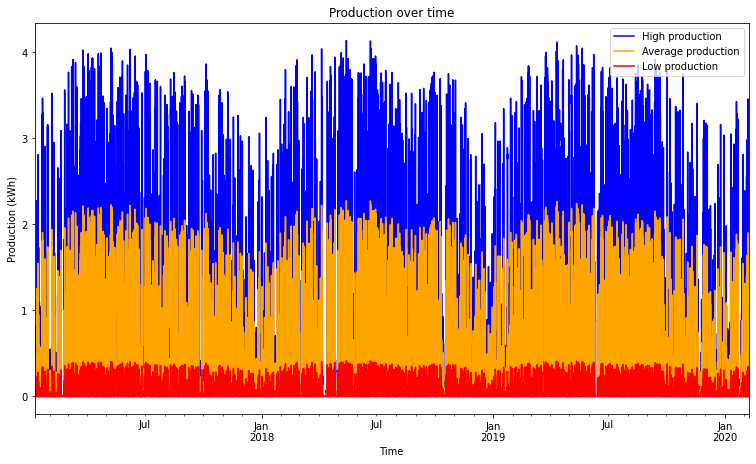

In [21]:
baseline_10 = baseline.copy()
baseline_10["high_production"] /= 10
baseline_10["low_production"] /= 10
baseline_10["avg_production"] /= 10

# barplot of production
baseline_10.plot(x="time", y=["high_production", "avg_production", "low_production"], figsize=(12.8, 7.2), color=["blue", "orange", "red"])
plt.title("Production over time")
plt.xlabel("Time")
plt.ylabel("Production (kWh)")
plt.legend(["High production", "Average production", "Low production"])
plt.show()

In [24]:
# lowest time in baseline
print(baseline.sort_values(by="time", ascending=True).head(1)["time"])
print(baseline.sort_values(by="time", ascending=True).tail(1)["time"])


0   2017-01-08 00:00:00+00:00
Name: time, dtype: datetime64[ns, UTC]
54048   2020-02-08 00:00:00+00:00
Name: time, dtype: datetime64[ns, UTC]


In [77]:
baseline_10.describe()

,energy,energy_pred,high_production,low_production,avg_production
count,54049.000000,54049.000000,54049.000000,54049.000000,54049.000000
mean,20.287596,20.307133,0.432068,0.043207,0.237637
std,10.314216,10.019979,0.968040,0.096804,0.532422
min,2.506500,2.833241,0.000000,0.000000,0.000000
25%,12.825000,12.962095,0.000000,0.000000,0.000000
50%,17.028000,17.352509,0.000000,0.000000,0.000000
75%,25.407000,25.373648,0.074419,0.007442,0.040931
max,76.893000,74.821167,4.136832,0.413683,2.275258


In [79]:
baseline_10.sum().apply(lambda x: f"{x:.4f}")

energy             1096524.3020
energy_pred        1097580.2500
high_production      23352.8281
low_production        2335.2828
avg_production       12844.0555
dtype: object

## Algoritmo Baseline

Tarifas

In [13]:
from datetime import timedelta, datetime
import pytz

def tarifa_bihoraria_diaria_ponta(time) -> bool:
    return time.hour >= 8 and time.hour < 22

def tarifa_bihoraria_semanal_ponta(time: datetime) -> bool:
    time = time.astimezone(pytz.timezone("Europe/Lisbon"))

    hour = time.hour
    # if it is daylight savings time
    if time.tz.dst != timedelta(0):
        if time.weekday() == 5:
            # it is saturday
            if hour < 9 or (hour >= 14 and hour < 20) or (hour >= 22):
                tarifa = False
            else:
                tarifa = True
        elif time.weekday() == 6:
            # it is sunday
            tarifa = False
        else:
            if hour < 7:
                tarifa = False
            else:
                tarifa = True
    else:
        if time.weekday() == 5:
            # it is saturday
            if (
                time.to_pydatetime()
                < datetime(
                    time.year,
                    time.month,
                    time.day,
                    9,
                    30,
                    0,
                    tzinfo=pytz.timezone("Europe/Lisbon"),
                )
                or (
                    time.to_pydatetime()
                    >= datetime(
                        time.year,
                        time.month,
                        time.day,
                        13,
                        0,
                        0,
                        tzinfo=pytz.timezone("Europe/Lisbon"),
                    )
                    and time.to_pydatetime()
                    < datetime(
                        time.year,
                        time.month,
                        time.day,
                        18,
                        30,
                        0,
                        tzinfo=pytz.timezone("Europe/Lisbon"),
                    )
                )
                or (
                    time.to_pydatetime()
                    >= datetime(
                        time.year,
                        time.month,
                        time.day,
                        22,
                        0,
                        0,
                        tzinfo=pytz.timezone("Europe/Lisbon"),
                    )
                )
            ):
                tarifa = False
            else:
                tarifa = True
        elif time.weekday() == 6:
            # it is sunday
            tarifa = False
        else:
            if hour < 7:
                tarifa = False
            else:
                tarifa = True
    return tarifa


No Production

In [14]:
def no_production(line: pd.array) -> pd.array:
    """No production scenario. All energy consumed comes from the grid."""
    # add prices
    tarifa_diario = TARIFA_PONTA if tarifa_bihoraria_diaria_ponta(line["time"]) else TARIFA_FORA_PONTA
    line["price_bihorario_diario"] = tarifa_diario * line["energy"]
    tarifa_semanal = TARIFA_PONTA if tarifa_bihoraria_semanal_ponta(line["time"]) else TARIFA_FORA_PONTA
    line["price_bihorario_semanal"] = tarifa_semanal * line["energy"]
    line["price_simples"] = TARIFA_SIMPLES * line["energy"]
    return line

no_prod = baseline[["time", "energy"]]
no_prod["time"] = pd.to_datetime(no_prod["time"])
no_prod = no_prod.apply(no_production, axis=1)
no_prod.sum().apply(lambda x: f"{x:.4f}")

energy                     1096524.3020
price_bihorario_diario      180566.7965
price_bihorario_semanal     179267.7419
price_simples               173579.7970
dtype: object

Algoritmo Baseline:
- No batteries in this scenario
- No AI/ML
- Consume production
- Fetch grid if still needed

In [15]:
def baseline_algorithm(line: pd.array) -> pd.array:
    """
    Baseline algorithm. Does not use batteries
    """
    to_consume = line["energy"]

    if to_consume > line["production"]:
        # there is NOT excess
        # consume all the energy produced
        to_consume -= line["production"]
        line["consumed_from_production"] = line["production"]
    else:
        # there is excess
        # consume the necessary energy produced
        line["consumed_from_production"] = to_consume
        to_consume = 0
    # fetch from grid the rest of the energy needed
    line["consumed_from_grid"] = to_consume

    # add prices
    tarifa_diario = TARIFA_PONTA if tarifa_bihoraria_diaria_ponta(line["time"]) else TARIFA_FORA_PONTA
    line["price_bihorario_diario"] = tarifa_diario * line["consumed_from_grid"]
    tarifa_semanal = TARIFA_PONTA if tarifa_bihoraria_semanal_ponta(line["time"]) else TARIFA_FORA_PONTA
    line["price_bihorario_semanal"] = tarifa_semanal * line["consumed_from_grid"]
    line["price_simples"] = TARIFA_SIMPLES * line["consumed_from_grid"]
    return line


In [16]:
low_prod_baseline = baseline.rename(columns={"low_production": "production"})
high_prod_baseline = baseline.rename(columns={"high_production": "production"})
avg_prod_baseline = baseline.rename(columns={"avg_production": "production"})

low_prod_baseline.drop(["high_production", "avg_production"], axis=1, inplace=True)
high_prod_baseline.drop(["low_production", "avg_production"], axis=1, inplace=True)
avg_prod_baseline.drop(["low_production", "high_production"], axis=1, inplace=True)

In [17]:
low_prod_baseline = low_prod_baseline.apply(baseline_algorithm, axis=1)
high_prod_baseline = high_prod_baseline.apply(baseline_algorithm, axis=1)
avg_prod_baseline = avg_prod_baseline.apply(baseline_algorithm, axis=1)


In [18]:
print("Baseline algorithm:")
print("High production:")
print(high_prod_baseline[["consumed_from_grid", "price_bihorario_diario", "price_bihorario_semanal", "price_simples"]].sum().apply(lambda x: f"{x:.4f}"))

print("Low production:")
print(low_prod_baseline[["consumed_from_grid", "price_bihorario_diario", "price_bihorario_semanal", "price_simples"]].sum().apply(lambda x: f"{x:.4f}"))

print("Avg production:")
print(avg_prod_baseline[["consumed_from_grid", "price_bihorario_diario", "price_bihorario_semanal", "price_simples"]].sum().apply(lambda x: f"{x:.4f}"))

Baseline algorithm:
High production:
consumed_from_grid         911704.3270
price_bihorario_diario     146364.0864
price_bihorario_semanal    146434.8987
price_simples              144322.7950
dtype: object
Low production:
consumed_from_grid         1073172.6156
price_bihorario_diario      176246.0450
price_bihorario_semanal     175254.3673
price_simples               169883.2251
dtype: object
Avg production:
consumed_from_grid         974987.5379
price_bihorario_diario     158095.2314
price_bihorario_semanal    158055.0320
price_simples              154340.5272
dtype: object


## Baseline + Battery Algorithm

Puts the excess energy in the battery and fetches from it if needed.

In [19]:
efficiency = 0.97
BATTERY_CAPACITY = 64

In [20]:
def baseline_battery_algorithm(line: pd.array, state_of_charge: float) -> tuple[pd.array, float]:
    """
    Uses the battery when there is excess or lack of energy. 
    Only if there is still energy missing, consume from grid.
    """
    line["battery_charge"] = state_of_charge
    # energy predicted to consume
    to_consume = line["energy"]

    # there is NOT excess
    if line["production"] < line["energy"]:
        # consume the energy produced
        to_consume -= line["production"]
        line["consumed_from_production"] = line["production"]

        # go fetch the rest to the battery
        if to_consume > line["battery_charge"]:
            # if the battery energy is not enough 
            # consume all the energy from the battery
            to_consume -= line["battery_charge"] * efficiency
            line["consumed_from_battery"] = line["battery_charge"] * efficiency
            # add loss from the battery
            line["losses"] = line["battery_charge"] * (1 - efficiency)
            line["battery_charge"] = 0
        else:
            # if the battery energy is enough
            line["battery_charge"] -= to_consume / efficiency
            line["consumed_from_battery"] = to_consume
            # add loss from the battery
            line["losses"] = to_consume * (1 - efficiency) / efficiency
            to_consume = 0
    else:
        # there is excess
        # consume the energy predicted to consume
        line["consumed_from_production"] = to_consume
        to_consume = 0

        # empty space in the battery
        possible_charge = BATTERY_CAPACITY - line["battery_charge"]
        # add the produced energy to the battery
        line["battery_charge"] += min((line["production"] - line["energy"]) * efficiency, possible_charge)
        # log the energy saved in the battery
        line["saved_to_battery"] += min((line["production"] - line["energy"]) * efficiency, possible_charge)
        line["losses"] += line["saved_to_battery"] * (1 - efficiency) / efficiency
        # send the rest of the energy to the grid
        line["send_to_grid"] = line["production"] - line["saved_to_battery"] - line["losses"]
    
    # fetch the rest of the energy to the grid
    line["consumed_from_grid"] += to_consume
    state_of_charge = line["battery_charge"]

    # add prices
    tarifa_diario = TARIFA_PONTA if tarifa_bihoraria_diaria_ponta(line["time"]) else TARIFA_FORA_PONTA
    line["price_bihorario_diario"] = tarifa_diario * line["consumed_from_grid"]
    tarifa_semanal = TARIFA_PONTA if tarifa_bihoraria_semanal_ponta(line["time"]) else TARIFA_FORA_PONTA
    line["price_bihorario_semanal"] = tarifa_semanal * line["consumed_from_grid"]
    line["price_simples"] = TARIFA_SIMPLES * line["consumed_from_grid"]
    return line, state_of_charge


In [21]:
low_prod_battery = low_prod_baseline.copy()
high_prod_battery = high_prod_baseline.copy()
avg_prod_battery = avg_prod_baseline.copy()

low_prod_battery["consumed_from_grid"] = 0
low_prod_battery["consumed_from_production"] = 0
low_prod_battery["consumed_from_battery"] = 0
low_prod_battery["saved_to_battery"] = 0
low_prod_battery["losses"] = 0
low_prod_battery["send_to_grid"] = 0
low_prod_battery["price_bihorario_diario"] = 0
low_prod_battery["price_bihorario_semanal"] = 0
low_prod_battery["price_simples"] = 0
low_prod_battery["battery_charge"] = 0

high_prod_battery["consumed_from_grid"] = 0
high_prod_battery["consumed_from_production"] = 0
high_prod_battery["consumed_from_battery"] = 0
high_prod_battery["saved_to_battery"] = 0
high_prod_battery["losses"] = 0
high_prod_battery["send_to_grid"] = 0
high_prod_battery["price_bihorario_diario"] = 0
high_prod_battery["price_bihorario_semanal"] = 0
high_prod_battery["price_simples"] = 0
high_prod_battery["battery_charge"] = 0

avg_prod_battery["consumed_from_grid"] = 0
avg_prod_battery["consumed_from_production"] = 0
avg_prod_battery["consumed_from_battery"] = 0
avg_prod_battery["saved_to_battery"] = 0
avg_prod_battery["losses"] = 0
avg_prod_battery["send_to_grid"] = 0
avg_prod_battery["price_bihorario_diario"] = 0
avg_prod_battery["price_bihorario_semanal"] = 0
avg_prod_battery["price_simples"] = 0
avg_prod_battery["battery_charge"] = 0

state_of_charge1 = 0
state_of_charge2 = 0
state_of_charge3 = 0

for i in tqdm(range(len(low_prod_battery))):
    low_prod_battery.iloc[i], state_of_charge1 = baseline_battery_algorithm(
        low_prod_battery.iloc[i], state_of_charge1
    )
    high_prod_battery.iloc[i], state_of_charge2 = baseline_battery_algorithm(
        high_prod_battery.iloc[i], state_of_charge2
    )
    avg_prod_battery.iloc[i], state_of_charge3 = baseline_battery_algorithm(
        avg_prod_battery.iloc[i], state_of_charge3
    )


100%|██████████| 54049/54049 [13:24<00:00, 67.16it/s]


In [22]:
high_prod_battery.describe()

,energy,energy_pred,production,consumed_from_production,consumed_from_grid,price_bihorario_diario,price_bihorario_semanal,price_simples,consumed_from_battery,saved_to_battery,losses,send_to_grid,battery_charge
count,54049.000000,54049.000000,54049.000000,54049.000000,54049.000000,54049.000000,54049.000000,54049.000000,54049.000000,54049.000000,54049.000000,54049.000000,54049.000000
mean,20.287596,20.307133,4.320677,3.419489,16.481880,2.635579,2.646992,2.609082,0.386227,0.398172,0.024260,2.185582,4.512525
std,10.314216,10.019980,9.680403,7.618918,11.300123,2.278256,2.291405,1.788809,2.005764,1.996734,0.085835,7.457883,14.518124
min,2.506500,2.833241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.495484,0.000000,-0.015324,0.000000,-0.510809
25%,12.825000,12.962095,0.000000,0.000000,10.802000,1.217565,1.202584,1.709957,0.000000,0.000000,0.000000,0.000000,0.000000
50%,17.028000,17.352509,0.000000,0.000000,14.775500,1.916366,1.890997,2.338962,0.000000,0.000000,0.000000,0.000000,0.000000
75%,25.407000,25.373648,0.744192,0.744192,21.673500,3.672589,3.784350,3.430915,0.000000,0.000000,0.000000,0.000000,0.000000
max,76.893000,74.821167,41.368320,39.704832,76.893000,14.740388,14.740388,12.172162,27.944616,28.232649,0.873175,41.368320,64.000000


In [23]:
print("Baseline + Battery")
print("High Production:")
print(high_prod_battery[["price_bihorario_diario", "price_bihorario_semanal", "price_simples", "consumed_from_grid"]].sum().apply(lambda x: f"{x:.4f}"))
print("Low Production:")
print(low_prod_battery[["price_bihorario_diario", "price_bihorario_semanal", "price_simples", "consumed_from_grid"]].sum().apply(lambda x: f"{x:.4f}"))
print("Average Production:")
print(avg_prod_battery[["price_bihorario_diario", "price_bihorario_semanal", "price_simples", "consumed_from_grid"]].sum().apply(lambda x: f"{x:.4f}"))


Baseline + Battery
High Production:
price_bihorario_diario     142450.4311
price_bihorario_semanal    143067.2891
price_simples              141018.2543
consumed_from_grid         890829.1492
dtype: object
Low Production:
price_bihorario_diario      176245.8391
price_bihorario_semanal     175254.2551
price_simples               169883.0550
consumed_from_grid         1073171.5413
dtype: object
Average Production:
price_bihorario_diario     157197.5983
price_bihorario_semanal    157407.9793
price_simples              153581.0264
consumed_from_grid         970189.6801
dtype: object


## Baseline + Battery + AI/ML Algorithm

### Midnight Consumption Prediction

Predict the consumption at midnight and then use it to predict the next half hour consumption.

In [47]:
midnight_consumption = energy_df.copy()

midnight_consumption.drop(["energy_pred"], axis=1, inplace=True)

midnight_consumption["time"] = pd.to_datetime(midnight_consumption["time"])

# # select rows at midnight
X = midnight_consumption.loc[(midnight_consumption["time"].dt.hour == 0) & (midnight_consumption["time"].dt.minute == 0)]
X = X.drop(["time", "energy", "location"], axis=1)

midnight_consumption.loc[(midnight_consumption["time"].dt.hour == 0) & (midnight_consumption["time"].dt.minute == 0), "energy_pred"] = model.predict(X)
midnight_consumption.head()


,location,time,energy,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336,energy_pred
45650,##Northgate House Electricity Supply 2,2017-01-08 00:00:00+00:00,0.342,0.339,0.332,0.342,0.334,0.335,0.334,0.346541
45651,##Northgate House Electricity Supply 2,2017-01-08 00:30:00+00:00,0.343,0.342,0.335,0.337,0.333,0.334,0.335,NaN
45652,##Northgate House Electricity Supply 2,2017-01-08 01:00:00+00:00,0.342,0.343,0.338,0.336,0.338,0.333,0.334,NaN
45653,##Northgate House Electricity Supply 2,2017-01-08 01:30:00+00:00,0.335,0.342,0.341,0.335,0.341,0.338,0.333,NaN
45654,##Northgate House Electricity Supply 2,2017-01-08 02:00:00+00:00,0.338,0.335,0.342,0.335,0.345,0.341,0.338,NaN


In [48]:
# shift energy 1
midnight_consumption["energy_shift_1"] = midnight_consumption["energy_pred"].shift(1)

# predict the full day
for i in tqdm(range(1, 48)):
    X = midnight_consumption.loc[
        (midnight_consumption["time"].dt.hour == i // 2)  # hour
        & (midnight_consumption["time"].dt.minute == i % 2 * 30)  # minute
    ]
    if i >= 46:  # use energy shift 46, instead of real energy, because the that part of the day is not available yet
        midnight_consumption["energy_shift_46"] = midnight_consumption["energy_pred"].shift(46)
        X = midnight_consumption.loc[
            (midnight_consumption["time"].dt.hour == i // 2)  # hour
            & (midnight_consumption["time"].dt.minute == i % 2 * 30)  # minute
        ]

        X = X[
            [
                "energy_shift_1",
                "energy_shift_46",
                "energy_lag_328",
                "energy_lag_328",
                "energy_lag_335",
                "energy_lag_336",
            ]
        ]
    else:
        X = X[
            [
                "energy_shift_1",
                "energy_lag_46",
                "energy_lag_328",
                "energy_lag_328",
                "energy_lag_335",
                "energy_lag_336",
            ]
        ]
    midnight_consumption.loc[
        (midnight_consumption["time"].dt.hour == i // 2)
        & (midnight_consumption["time"].dt.minute == i % 2 * 30),
        "energy_pred",
    ] = model.predict(X)
    midnight_consumption["energy_shift_1"] = midnight_consumption["energy_pred"].shift(1)

midnight_consumption.head()


100%|██████████| 47/47 [00:12<00:00,  3.90it/s]


,location,time,energy,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336,energy_pred,energy_shift_1,energy_shift_46
45650,##Northgate House Electricity Supply 2,2017-01-08 00:00:00+00:00,0.342,0.339,0.332,0.342,0.334,0.335,0.334,0.346541,NaN,NaN
45651,##Northgate House Electricity Supply 2,2017-01-08 00:30:00+00:00,0.343,0.342,0.335,0.337,0.333,0.334,0.335,0.350093,0.346541,NaN
45652,##Northgate House Electricity Supply 2,2017-01-08 01:00:00+00:00,0.342,0.343,0.338,0.336,0.338,0.333,0.334,0.347754,0.350093,NaN
45653,##Northgate House Electricity Supply 2,2017-01-08 01:30:00+00:00,0.335,0.342,0.341,0.335,0.341,0.338,0.333,0.350093,0.347754,NaN
45654,##Northgate House Electricity Supply 2,2017-01-08 02:00:00+00:00,0.338,0.335,0.342,0.335,0.345,0.341,0.338,0.350093,0.350093,NaN


In [49]:
midnight_consumption["time"] = pd.to_datetime(midnight_consumption["time"])
cons_m1 = midnight_consumption[(midnight_consumption["time"].dt.hour >= 9) & (midnight_consumption["time"].dt.hour <= 18)]
cons_m1 = cons_m1.groupby(cons_m1["time"].dt.date).sum()
cons_m1 = cons_m1[["energy_pred"]]

cons_m1.head()

,energy_pred
time,
2017-01-08,260.738770
2017-01-09,286.047119
2017-01-10,655.025269
2017-01-11,728.638794
2017-01-12,726.581177


In [50]:
cons_m2 = midnight_consumption[(midnight_consumption.time.dt.hour >= 6) & (midnight_consumption.time.dt.hour <= 9)]
cons_m2 = cons_m2.groupby(cons_m2.time.dt.date).sum()
cons_m2 = cons_m2[["energy_pred"]]

cons_m2.head()


,energy_pred
time,
2017-01-08,118.441208
2017-01-09,130.730865
2017-01-10,204.125427
2017-01-11,210.173065
2017-01-12,218.266968


In [51]:
# sum the energy in a day
consumption_pred = midnight_consumption.groupby(midnight_consumption["time"].dt.date).sum()
# midnight_consumption.drop("time", axis=1, inplace=True)
consumption_pred.head()


,energy,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336,energy_pred,energy_shift_1,energy_shift_46
time,,,,,,,,,,
2017-01-08,704.6990,704.8260,776.9045,636.7765,626.2460,623.0270,621.4795,666.873413,669.836426,1377.887817
2017-01-09,1212.0825,1213.1880,704.6655,737.2205,736.7910,737.9110,737.8375,719.015198,718.169800,656.380249
2017-01-10,1271.3735,1270.3910,1210.5335,1141.2470,1140.7555,1141.0375,1140.6610,1149.309204,1149.679810,704.913452
2017-01-11,1152.8515,1152.8605,1271.6145,1215.4875,1212.2645,1211.7735,1210.8200,1229.814575,1228.956787,1137.582275
2017-01-12,1249.3505,1247.8710,1153.0790,1287.2605,1285.9060,1285.1790,1285.8375,1249.597656,1249.213135,1216.762085


In [52]:
consumption_pred = consumption_pred[["energy", "energy_pred"]]
consumption_pred.head()

,energy,energy_pred
time,,
2017-01-08,704.6990,666.873413
2017-01-09,1212.0825,719.015198
2017-01-10,1271.3735,1149.309204
2017-01-11,1152.8515,1229.814575
2017-01-12,1249.3505,1249.597656


In [53]:
production_pred = energy_pred_df.groupby(energy_pred_df["time"].dt.date).sum()
production_pred.head()

,energy,energy_pred,Dni
time,,,
2017-01-08,704.6990,693.797485,0.311
2017-01-09,1212.0825,1076.781860,0.126
2017-01-10,1271.3735,1238.020996,0.000
2017-01-11,1152.8515,1178.930542,3.595
2017-01-12,1249.3505,1252.612061,0.000


In [54]:
low_production_pred = production_pred.copy()
high_production_pred = production_pred.copy()
avg_production_pred = production_pred.copy()

low_production_pred["production"] = low_production_pred["Dni"] * LOW_PRODUCTION
high_production_pred["production"] = high_production_pred["Dni"] * HIGH_PRODUCTION
avg_production_pred["production"] = avg_production_pred["Dni"] * AVG_PRODUCTION

low_production_pred = low_production_pred[["production"]]
high_production_pred = high_production_pred[["production"]]
avg_production_pred = avg_production_pred[["production"]]

In [55]:
high_production_pred.describe()

,production
count,1127.000000
mean,207.212317
std,239.687603
min,0.000000
25%,13.351680
50%,111.103488
75%,330.859008
max,1015.034112


In [56]:
# parse the index to string
low_production_pred.index = low_production_pred.index.astype(str)
high_production_pred.index = high_production_pred.index.astype(str)
avg_production_pred.index = avg_production_pred.index.astype(str)

consumption_pred.index = consumption_pred.index.astype(str)

cons_m1.index = cons_m1.index.astype(str)
cons_m2.index = cons_m2.index.astype(str)

high_production_pred.head()

,production
time,
2017-01-08,13.614336
2017-01-09,5.515776
2017-01-10,0.000000
2017-01-11,157.374720
2017-01-12,0.000000


In [63]:
# performance metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

midnight_consumption["time"] = pd.to_datetime(midnight_consumption["time"])
grouped_consumption = midnight_consumption.groupby(midnight_consumption["time"]).sum()

mse = mean_squared_error(grouped_consumption["energy"], grouped_consumption["energy_pred"])
rmse = np.sqrt(mse)
mae = mean_absolute_error(grouped_consumption["energy"], grouped_consumption["energy_pred"])
r2 = r2_score(grouped_consumption["energy"], grouped_consumption["energy_pred"])
mape = mean_absolute_percentage_error(grouped_consumption["energy"], grouped_consumption["energy_pred"])

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R2: {r2}")

MAE: 2.6360657647397243
MSE: 17.06033331927676
RMSE: 4.130415635172417
MAPE: 0.1333311535026286
R2: 0.8396300139182368


In [66]:
grouped_consumption = energy_df.groupby(energy_df["time"]).sum()

mse = mean_squared_error(grouped_consumption["energy"], grouped_consumption["energy_pred"])
rmse = np.sqrt(mse)
mae = mean_absolute_error(grouped_consumption["energy"], grouped_consumption["energy_pred"])
r2 = r2_score(grouped_consumption["energy"], grouped_consumption["energy_pred"])
mape = mean_absolute_percentage_error(grouped_consumption["energy"], grouped_consumption["energy_pred"])

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R2: {r2}")

MAE: 1.181869253403018
MSE: 3.192910767751453
RMSE: 1.7868717826837641
MAPE: 0.061066897782907144
R2: 0.9699861048549361


Text(0.5, 1.0, 'Energy consumption and all-day prediction')

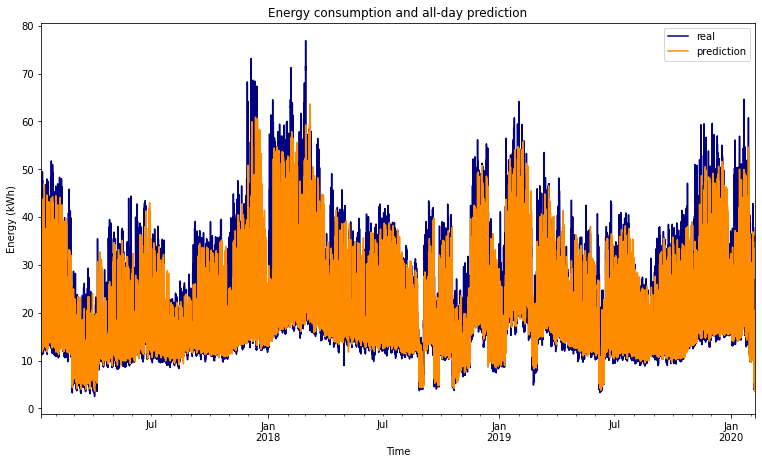

In [74]:
grouped_consumption_allday = midnight_consumption.groupby(midnight_consumption["time"]).sum().reset_index()

ax = grouped_consumption_allday.plot(x="time", y="energy", label="real", c="navy", figsize=(12.8, 7.2))
grouped_consumption_allday.plot(x="time", y="energy_pred", label="prediction", c="darkorange", ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Energy (kWh)")
ax.legend()
# set title
ax.set_title("Energy consumption and all-day prediction")

Text(0.5, 1.0, 'Energy consumption and short-term prediction')

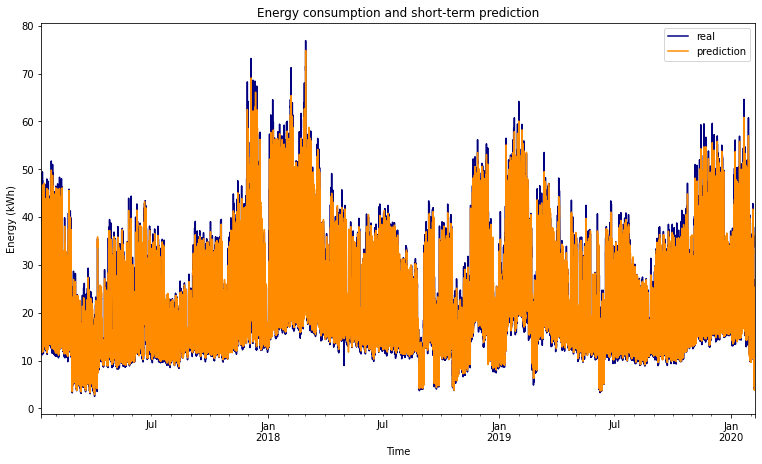

In [75]:
grouped_consumption_shortterm = energy_df.groupby(energy_df["time"]).sum().reset_index()
grouped_consumption_shortterm["time"] = pd.to_datetime(grouped_consumption_shortterm["time"])
ax = grouped_consumption_shortterm.plot(x="time", y="energy", label="real", c="navy", figsize=(12.8, 7.2))
grouped_consumption_shortterm.plot(x="time", y="energy_pred", label="prediction", c="darkorange", ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Energy (kWh)")
ax.legend()
# set title
ax.set_title("Energy consumption and short-term prediction")

### Algorithm

In [34]:
def battery_ml_algorithm(line: pd.array, state_of_charge: float, production_pred: pd.DataFrame, tarifa) -> tuple[pd.array, float]:
    """
    Battery ML algorithm
    """
    # battery available
    battery_available = BATTERY_CAPACITY - state_of_charge
    day = str(line["time"].strftime("%Y-%m-%d"))
    if line.time.hour == 0 and line.time.minute == 0:
        # it is midnight
        consumption_prediction = consumption_pred.loc[day]["energy_pred"]
        production_prediction = production_pred.loc[day]["production"]

        m1 = cons_m1.loc[day]["energy_pred"] / consumption_prediction
        m2 = cons_m2.loc[day]["energy_pred"] / consumption_prediction

        if production_prediction > consumption_prediction * m1:
            # production is greater than consumption

            excess = production_prediction - consumption_prediction * m1

            if excess < battery_available:
                # battery is NOT full
                # charge battery with the excess
                state_of_charge += battery_available - excess
                line["consumed_from_grid"] += (battery_available - excess) / efficiency
                line["saved_to_battery"] += battery_available - excess
                line["losses"] += (
                    (battery_available - excess) * (1 - efficiency) / efficiency
                )
            else:
                # battery will be full
                # charge battery with the consumption in the morning
                state_of_charge += min(consumption_prediction * m2, battery_available)
                line["consumed_from_grid"] += min(
                    consumption_prediction * m2, battery_available
                ) / efficiency
                line["saved_to_battery"] += min(
                    consumption_prediction * m2, battery_available
                )
                line["losses"] += min(consumption_prediction * m2, battery_available) * (
                    1 - efficiency
                ) / efficiency
        else:
            # production is smaller than consumption
            # pre-charge battery to its full capacity
            state_of_charge += battery_available
            line["consumed_from_grid"] += battery_available / efficiency
            line["saved_to_battery"] += battery_available
            line["losses"] += battery_available * (1 - efficiency) / efficiency

    if not tarifa(line.time):
        # not hora de ponta

        to_consume = line["energy"]
        # only consume from production and grid
        # if the energy predicted to consume is greater than the energy produced
        if line["production"] < line["energy"]:
            # consume the energy produced
            to_consume -= line["production"]
            line["consumed_from_production"] += line["production"]
        else:
            # if the energy predicted to consume is less than the energy produced
            # consume the energy predicted to consume
            line["consumed_from_production"] = to_consume
            to_consume = 0

            # add the produced energy to the battery
            state_of_charge += min(
                (line["production"] - line["energy"]) * efficiency, battery_available
            )
            # log the energy saved in the battery
            line["saved_to_battery"] += min(
                (line["production"] - line["energy"]) * efficiency, battery_available
            )
            # log the losses
            line["losses"] += line["saved_to_battery"] * (1 - efficiency) / efficiency
            # send the rest of the energy to the grid
            line["send_to_grid"] = line["production"] - line["saved_to_battery"] - line["losses"]

        # fetch the rest of the energy to the grid
        line["consumed_from_grid"] += to_consume
        line["battery_charge"] = state_of_charge

        # add prices
        tarifa_diario = TARIFA_PONTA if tarifa_bihoraria_diaria_ponta(line["time"]) else TARIFA_FORA_PONTA
        line["price_bihorario_diario"] = tarifa_diario * line["consumed_from_grid"]
        tarifa_semanal = TARIFA_PONTA if tarifa_bihoraria_semanal_ponta(line["time"]) else TARIFA_FORA_PONTA
        line["price_bihorario_semanal"] = tarifa_semanal * line["consumed_from_grid"]
        line["price_simples"] = TARIFA_SIMPLES * line["consumed_from_grid"]
        return line, state_of_charge

    return baseline_battery_algorithm(line, state_of_charge)



In [35]:
low_prod_battery_ml = low_prod_battery.copy()
high_prod_battery_ml = high_prod_battery.copy()
avg_prod_battery_ml = avg_prod_battery.copy()

# remove the last row
low_prod_battery_ml = low_prod_battery_ml.iloc[:-1]
high_prod_battery_ml = high_prod_battery_ml.iloc[:-1]
avg_prod_battery_ml = avg_prod_battery_ml.iloc[:-1]

low_prod_battery_ml["consumed_from_grid"] = 0
low_prod_battery_ml["consumed_from_production"] = 0
low_prod_battery_ml["consumed_from_battery"] = 0
low_prod_battery_ml["saved_to_battery"] = 0
low_prod_battery_ml["losses"] = 0
low_prod_battery_ml["send_to_grid"] = 0
low_prod_battery_ml["price_bihorario_diario"] = 0
low_prod_battery_ml["price_bihorario_semanal"] = 0
low_prod_battery_ml["price_simples"] = 0
low_prod_battery_ml["battery_charge"] = 0

high_prod_battery_ml["consumed_from_grid"] = 0
high_prod_battery_ml["consumed_from_production"] = 0
high_prod_battery_ml["consumed_from_battery"] = 0
high_prod_battery_ml["saved_to_battery"] = 0
high_prod_battery_ml["losses"] = 0
high_prod_battery_ml["send_to_grid"] = 0
high_prod_battery_ml["price_bihorario_diario"] = 0
high_prod_battery_ml["price_bihorario_semanal"] = 0
high_prod_battery_ml["price_simples"] = 0
high_prod_battery_ml["battery_charge"] = 0

avg_prod_battery_ml["consumed_from_grid"] = 0
avg_prod_battery_ml["consumed_from_production"] = 0
avg_prod_battery_ml["consumed_from_battery"] = 0
avg_prod_battery_ml["saved_to_battery"] = 0
avg_prod_battery_ml["losses"] = 0
avg_prod_battery_ml["send_to_grid"] = 0
avg_prod_battery_ml["price_bihorario_diario"] = 0
avg_prod_battery_ml["price_bihorario_semanal"] = 0
avg_prod_battery_ml["price_simples"] = 0
avg_prod_battery_ml["battery_charge"] = 0

state_of_charge1 = 0
state_of_charge2 = 0
state_of_charge3 = 0

high_prod_battery_ml["time"] = pd.to_datetime(high_prod_battery_ml["time"])
low_prod_battery_ml["time"] = pd.to_datetime(low_prod_battery_ml["time"])
avg_prod_battery_ml["time"] = pd.to_datetime(avg_prod_battery_ml["time"])

for i in tqdm(range(len(low_prod_battery_ml))):
    high_prod_battery_ml.iloc[i], state_of_charge1 = battery_ml_algorithm(
        high_prod_battery_ml.iloc[i],
        state_of_charge1,
        high_production_pred,
        lambda time: time.hour >= 10,
    )
    low_prod_battery_ml.iloc[i], state_of_charge2 = battery_ml_algorithm(
        low_prod_battery_ml.iloc[i],
        state_of_charge2,
        low_production_pred,
        lambda time: time.hour >= 10,
    )
    avg_prod_battery_ml.iloc[i], state_of_charge3 = battery_ml_algorithm(
        avg_prod_battery_ml.iloc[i],
        state_of_charge3,
        avg_production_pred,
        lambda time: time.hour >= 10,
    )


100%|██████████| 54048/54048 [14:04<00:00, 64.02it/s]


In [36]:
print("Baseline + Battery + ML")
print("High Production:")
print(high_prod_battery_ml[["price_bihorario_diario", "price_bihorario_semanal", "price_simples", "consumed_from_grid"]].sum().apply(lambda x: f"{x:.4f}"))
print("Low Production:")
print(low_prod_battery_ml[["price_bihorario_diario", "price_bihorario_semanal", "price_simples", "consumed_from_grid"]].sum().apply(lambda x: f"{x:.4f}"))
print("Average Production:")
print(avg_prod_battery_ml[["price_bihorario_diario", "price_bihorario_semanal", "price_simples", "consumed_from_grid"]].sum().apply(lambda x: f"{x:.4f}"))


Baseline + Battery + ML
High Production:
price_bihorario_diario     139383.8501
price_bihorario_semanal    140596.9407
price_simples              143782.7660
consumed_from_grid         908292.8994
dtype: object
Low Production:
price_bihorario_diario      170603.1347
price_bihorario_semanal     170493.2605
price_simples               170577.4541
consumed_from_grid         1077558.1433
dtype: object
Average Production:
price_bihorario_diario     152148.1554
price_bihorario_semanal    153135.0939
price_simples              154709.9357
consumed_from_grid         977321.1353
dtype: object


# Sell Grid gains

In [37]:
print("High:", (high_prod_battery["send_to_grid"] * 0.03).sum())
print("Low", (low_prod_battery["send_to_grid"] * 0.03).sum())
print("Avg", (avg_prod_battery["send_to_grid"] * 0.03).sum())

High: 3543.855381016847
Low 0.8308049999999999
Avg 650.05131989931


In [38]:
print("High:", (high_prod_battery_ml["send_to_grid"] * 0.03).sum())
print("Low", (low_prod_battery_ml["send_to_grid"] * 0.03).sum())
print("Avg", (avg_prod_battery_ml["send_to_grid"] * 0.03).sum())

High: 3962.551034267548
Low 0.8308049999999999
Avg 739.1023162124113


# High Storage Capacity

In [39]:
BATTERY_CAPACITY = 128

In [40]:
high_prod_baseline["consumed_from_grid"] = 0
high_prod_baseline["consumed_from_production"] = 0
high_prod_baseline["consumed_from_battery"] = 0
high_prod_baseline["saved_to_battery"] = 0
high_prod_baseline["losses"] = 0
high_prod_baseline["send_to_grid"] = 0
high_prod_baseline["price_bihorario_diario"] = 0
high_prod_baseline["price_bihorario_semanal"] = 0
high_prod_baseline["price_simples"] = 0
high_prod_baseline["battery_charge"] = 0

low_prod_baseline["consumed_from_grid"] = 0
low_prod_baseline["consumed_from_production"] = 0
low_prod_baseline["consumed_from_battery"] = 0
low_prod_baseline["saved_to_battery"] = 0
low_prod_baseline["losses"] = 0
low_prod_baseline["send_to_grid"] = 0
low_prod_baseline["price_bihorario_diario"] = 0
low_prod_baseline["price_bihorario_semanal"] = 0
low_prod_baseline["price_simples"] = 0
low_prod_baseline["battery_charge"] = 0

avg_prod_baseline["consumed_from_grid"] = 0
avg_prod_baseline["consumed_from_production"] = 0
avg_prod_baseline["consumed_from_battery"] = 0
avg_prod_baseline["saved_to_battery"] = 0
avg_prod_baseline["losses"] = 0
avg_prod_baseline["send_to_grid"] = 0
avg_prod_baseline["price_bihorario_diario"] = 0
avg_prod_baseline["price_bihorario_semanal"] = 0
avg_prod_baseline["price_simples"] = 0
avg_prod_baseline["battery_charge"] = 0

high_prod_baseline = high_prod_baseline.apply(baseline_algorithm, axis=1)
low_prod_baseline = low_prod_baseline.apply(baseline_algorithm, axis=1)
avg_prod_baseline = avg_prod_baseline.apply(baseline_algorithm, axis=1)

print("Baseline")
print("High Production:")
print(high_prod_baseline[["price_bihorario_diario", "price_bihorario_semanal", "price_simples", "consumed_from_grid"]].sum().apply(lambda x: f"{x:.4f}"))
print("Low Production:")
print(low_prod_baseline[["price_bihorario_diario", "price_bihorario_semanal", "price_simples", "consumed_from_grid"]].sum().apply(lambda x: f"{x:.4f}"))
print("Average Production:")
print(avg_prod_baseline[["price_bihorario_diario", "price_bihorario_semanal", "price_simples", "consumed_from_grid"]].sum().apply(lambda x: f"{x:.4f}"))


Baseline
High Production:
price_bihorario_diario     146364.0864
price_bihorario_semanal    146434.8987
price_simples              144322.7950
consumed_from_grid         911704.3270
dtype: object
Low Production:
price_bihorario_diario      176246.0450
price_bihorario_semanal     175254.3673
price_simples               169883.2251
consumed_from_grid         1073172.6156
dtype: object
Average Production:
price_bihorario_diario     158095.2314
price_bihorario_semanal    158055.0320
price_simples              154340.5272
consumed_from_grid         974987.5379
dtype: object


In [41]:
high_prod_battery["consumed_from_grid"] = 0
high_prod_battery["consumed_from_production"] = 0
high_prod_battery["consumed_from_battery"] = 0
high_prod_battery["saved_to_battery"] = 0
high_prod_battery["losses"] = 0
high_prod_battery["send_to_grid"] = 0
high_prod_battery["price_bihorario_diario"] = 0
high_prod_battery["price_bihorario_semanal"] = 0
high_prod_battery["price_simples"] = 0
high_prod_battery["battery_charge"] = 0

low_prod_battery["consumed_from_grid"] = 0
low_prod_battery["consumed_from_production"] = 0
low_prod_battery["consumed_from_battery"] = 0
low_prod_battery["saved_to_battery"] = 0
low_prod_battery["losses"] = 0
low_prod_battery["send_to_grid"] = 0
low_prod_battery["price_bihorario_diario"] = 0
low_prod_battery["price_bihorario_semanal"] = 0
low_prod_battery["price_simples"] = 0
low_prod_battery["battery_charge"] = 0

avg_prod_battery["consumed_from_grid"] = 0
avg_prod_battery["consumed_from_production"] = 0
avg_prod_battery["consumed_from_battery"] = 0
avg_prod_battery["saved_to_battery"] = 0
avg_prod_battery["losses"] = 0
avg_prod_battery["send_to_grid"] = 0
avg_prod_battery["price_bihorario_diario"] = 0
avg_prod_battery["price_bihorario_semanal"] = 0
avg_prod_battery["price_simples"] = 0
avg_prod_battery["battery_charge"] = 0

state_of_charge1 = 0
state_of_charge2 = 0
state_of_charge3 = 0

for i in tqdm(range(len(high_prod_battery))):
    high_prod_battery.iloc[i], state_of_charge1 = baseline_battery_algorithm(high_prod_battery.iloc[i], state_of_charge1)
    low_prod_battery.iloc[i], state_of_charge2 = baseline_battery_algorithm(low_prod_battery.iloc[i], state_of_charge2)
    avg_prod_battery.iloc[i], state_of_charge3 = baseline_battery_algorithm(avg_prod_battery.iloc[i], state_of_charge3)

print("Battery")
print("High Production:")
print(high_prod_battery[["price_bihorario_diario", "price_bihorario_semanal", "price_simples", "consumed_from_grid"]].sum().apply(lambda x: f"{x:.4f}"))
print("Low Production:")
print(low_prod_battery[["price_bihorario_diario", "price_bihorario_semanal", "price_simples", "consumed_from_grid"]].sum().apply(lambda x: f"{x:.4f}"))
print("Average Production:")
print(avg_prod_battery[["price_bihorario_diario", "price_bihorario_semanal", "price_simples", "consumed_from_grid"]].sum().apply(lambda x: f"{x:.4f}"))


100%|██████████| 54049/54049 [14:25<00:00, 62.47it/s]


Baseline
High Production:
price_bihorario_diario     141156.8138
price_bihorario_semanal    141839.1973
price_simples              139530.9425
consumed_from_grid         881433.6229
dtype: object
Low Production:
price_bihorario_diario      176245.8391
price_bihorario_semanal     175254.2551
price_simples               169883.0550
consumed_from_grid         1073171.5413
dtype: object
Average Production:
price_bihorario_diario     157072.5016
price_bihorario_semanal    157303.6038
price_simples              153423.6417
consumed_from_grid         969195.4626
dtype: object


In [42]:
high_prod_battery_ml["consumed_from_grid"] = 0
high_prod_battery_ml["consumed_from_production"] = 0
high_prod_battery_ml["consumed_from_battery"] = 0
high_prod_battery_ml["saved_to_battery"] = 0
high_prod_battery_ml["losses"] = 0
high_prod_battery_ml["send_to_grid"] = 0
high_prod_battery_ml["price_bihorario_diario"] = 0
high_prod_battery_ml["price_bihorario_semanal"] = 0
high_prod_battery_ml["price_simples"] = 0
high_prod_battery_ml["battery_charge"] = 0

low_prod_battery_ml["consumed_from_grid"] = 0
low_prod_battery_ml["consumed_from_production"] = 0
low_prod_battery_ml["consumed_from_battery"] = 0
low_prod_battery_ml["saved_to_battery"] = 0
low_prod_battery_ml["losses"] = 0
low_prod_battery_ml["send_to_grid"] = 0
low_prod_battery_ml["price_bihorario_diario"] = 0
low_prod_battery_ml["price_bihorario_semanal"] = 0
low_prod_battery_ml["price_simples"] = 0
low_prod_battery_ml["battery_charge"] = 0

avg_prod_battery_ml["consumed_from_grid"] = 0
avg_prod_battery_ml["consumed_from_production"] = 0
avg_prod_battery_ml["consumed_from_battery"] = 0
avg_prod_battery_ml["saved_to_battery"] = 0
avg_prod_battery_ml["losses"] = 0
avg_prod_battery_ml["send_to_grid"] = 0
avg_prod_battery_ml["price_bihorario_diario"] = 0
avg_prod_battery_ml["price_bihorario_semanal"] = 0
avg_prod_battery_ml["price_simples"] = 0
avg_prod_battery_ml["battery_charge"] = 0

state_of_charge1 = 0
state_of_charge2 = 0
state_of_charge3 = 0


for i in tqdm(range(len(high_prod_battery_ml))):
    high_prod_battery_ml.iloc[i], state_of_charge1 = battery_ml_algorithm(high_prod_battery_ml.iloc[i], state_of_charge1, high_production_pred, lambda time: time.hour >= 10)
    low_prod_battery_ml.iloc[i], state_of_charge2 = battery_ml_algorithm(low_prod_battery_ml.iloc[i], state_of_charge2, low_production_pred, lambda time: time.hour >= 10)
    avg_prod_battery_ml.iloc[i], state_of_charge3 = battery_ml_algorithm(avg_prod_battery_ml.iloc[i], state_of_charge3, avg_production_pred, lambda time: time.hour >= 10)

print("Battery + ML")
print("High Production:")
print(high_prod_battery_ml[["price_bihorario_diario", "price_bihorario_semanal", "price_simples", "consumed_from_grid"]].sum().apply(lambda x: f"{x:.4f}"))
print("Low Production:")
print(low_prod_battery_ml[["price_bihorario_diario", "price_bihorario_semanal", "price_simples", "consumed_from_grid"]].sum().apply(lambda x: f"{x:.4f}"))
print("Average Production:")
print(avg_prod_battery_ml[["price_bihorario_diario", "price_bihorario_semanal", "price_simples", "consumed_from_grid"]].sum().apply(lambda x: f"{x:.4f}"))


100%|██████████| 54048/54048 [14:27<00:00, 62.28it/s]

Baseline
High Production:
price_bihorario_diario     134022.1132
price_bihorario_semanal    136052.6837
price_simples              143861.1967
consumed_from_grid         908788.3554
dtype: object
Low Production:
price_bihorario_diario      164985.8465
price_bihorario_semanal     165993.5342
price_simples               171270.9205
consumed_from_grid         1081938.8536
dtype: object
Average Production:
price_bihorario_diario     146649.8202
price_bihorario_semanal    148628.7988
price_simples              155221.9399
consumed_from_grid         980555.5266
dtype: object


## Sell Grid gains

In [43]:
print("High:", (high_prod_battery["send_to_grid"] * 0.03).sum())
print("Low", (low_prod_battery["send_to_grid"] * 0.03).sum())
print("Avg", (avg_prod_battery["send_to_grid"] * 0.03).sum())

High: 3244.2849815652075
Low 0.8308049999999999
Avg 618.3513239408047


In [44]:
print("High:", (high_prod_battery_ml["send_to_grid"] * 0.03).sum())
print("Low", (low_prod_battery_ml["send_to_grid"] * 0.03).sum())
print("Avg", (avg_prod_battery_ml["send_to_grid"] * 0.03).sum())

High: 3851.365129030812
Low 0.8308049999999999
Avg 706.7874527218187


In [51]:
HIGH_PRODUCTION / 10, LOW_PRODUCTION / 10, AVG_PRODUCTION / 10

(4.377599999999999, 0.43776000000000004, 2.40768)

# Low Production

In [45]:
BATTERY_CAPACITY = 16

In [46]:
high_prod_baseline["consumed_from_grid"] = 0
high_prod_baseline["consumed_from_production"] = 0
high_prod_baseline["consumed_from_battery"] = 0
high_prod_baseline["saved_to_battery"] = 0
high_prod_baseline["losses"] = 0
high_prod_baseline["send_to_grid"] = 0
high_prod_baseline["price_bihorario_diario"] = 0
high_prod_baseline["price_bihorario_semanal"] = 0
high_prod_baseline["price_simples"] = 0
high_prod_baseline["battery_charge"] = 0

low_prod_baseline["consumed_from_grid"] = 0
low_prod_baseline["consumed_from_production"] = 0
low_prod_baseline["consumed_from_battery"] = 0
low_prod_baseline["saved_to_battery"] = 0
low_prod_baseline["losses"] = 0
low_prod_baseline["send_to_grid"] = 0
low_prod_baseline["price_bihorario_diario"] = 0
low_prod_baseline["price_bihorario_semanal"] = 0
low_prod_baseline["price_simples"] = 0
low_prod_baseline["battery_charge"] = 0

avg_prod_baseline["consumed_from_grid"] = 0
avg_prod_baseline["consumed_from_production"] = 0
avg_prod_baseline["consumed_from_battery"] = 0
avg_prod_baseline["saved_to_battery"] = 0
avg_prod_baseline["losses"] = 0
avg_prod_baseline["send_to_grid"] = 0
avg_prod_baseline["price_bihorario_diario"] = 0
avg_prod_baseline["price_bihorario_semanal"] = 0
avg_prod_baseline["price_simples"] = 0
avg_prod_baseline["battery_charge"] = 0

high_prod_baseline = high_prod_baseline.apply(baseline_algorithm, axis=1)
low_prod_baseline = low_prod_baseline.apply(baseline_algorithm, axis=1)
avg_prod_baseline = avg_prod_baseline.apply(baseline_algorithm, axis=1)

print("Baseline")
print("High Production:")
print(high_prod_baseline[["price_bihorario_diario", "price_bihorario_semanal", "price_simples", "consumed_from_grid"]].sum().apply(lambda x: f"{x:.4f}"))
print("Low Production:")
print(low_prod_baseline[["price_bihorario_diario", "price_bihorario_semanal", "price_simples", "consumed_from_grid"]].sum().apply(lambda x: f"{x:.4f}"))
print("Average Production:")
print(avg_prod_baseline[["price_bihorario_diario", "price_bihorario_semanal", "price_simples", "consumed_from_grid"]].sum().apply(lambda x: f"{x:.4f}"))


Baseline
High Production:
price_bihorario_diario     146364.0864
price_bihorario_semanal    146434.8987
price_simples              144322.7950
consumed_from_grid         911704.3270
dtype: object
Low Production:
price_bihorario_diario      176246.0450
price_bihorario_semanal     175254.3673
price_simples               169883.2251
consumed_from_grid         1073172.6156
dtype: object
Average Production:
price_bihorario_diario     158095.2314
price_bihorario_semanal    158055.0320
price_simples              154340.5272
consumed_from_grid         974987.5379
dtype: object


In [47]:
high_prod_battery["consumed_from_grid"] = 0
high_prod_battery["consumed_from_production"] = 0
high_prod_battery["consumed_from_battery"] = 0
high_prod_battery["saved_to_battery"] = 0
high_prod_battery["losses"] = 0
high_prod_battery["send_to_grid"] = 0
high_prod_battery["price_bihorario_diario"] = 0
high_prod_battery["price_bihorario_semanal"] = 0
high_prod_battery["price_simples"] = 0
high_prod_battery["battery_charge"] = 0

low_prod_battery["consumed_from_grid"] = 0
low_prod_battery["consumed_from_production"] = 0
low_prod_battery["consumed_from_battery"] = 0
low_prod_battery["saved_to_battery"] = 0
low_prod_battery["losses"] = 0
low_prod_battery["send_to_grid"] = 0
low_prod_battery["price_bihorario_diario"] = 0
low_prod_battery["price_bihorario_semanal"] = 0
low_prod_battery["price_simples"] = 0
low_prod_battery["battery_charge"] = 0

avg_prod_battery["consumed_from_grid"] = 0
avg_prod_battery["consumed_from_production"] = 0
avg_prod_battery["consumed_from_battery"] = 0
avg_prod_battery["saved_to_battery"] = 0
avg_prod_battery["losses"] = 0
avg_prod_battery["send_to_grid"] = 0
avg_prod_battery["price_bihorario_diario"] = 0
avg_prod_battery["price_bihorario_semanal"] = 0
avg_prod_battery["price_simples"] = 0
avg_prod_battery["battery_charge"] = 0

state_of_charge1 = 0
state_of_charge2 = 0
state_of_charge3 = 0

for i in tqdm(range(len(high_prod_battery))):
    high_prod_battery.iloc[i], state_of_charge1 = baseline_battery_algorithm(high_prod_battery.iloc[i], state_of_charge1)
    low_prod_battery.iloc[i], state_of_charge2 = baseline_battery_algorithm(low_prod_battery.iloc[i], state_of_charge2)
    avg_prod_battery.iloc[i], state_of_charge3 = baseline_battery_algorithm(avg_prod_battery.iloc[i], state_of_charge3)

print("Baseline")
print("High Production:")
print(high_prod_battery[["price_bihorario_diario", "price_bihorario_semanal", "price_simples", "consumed_from_grid"]].sum().apply(lambda x: f"{x:.4f}"))
print("Low Production:")
print(low_prod_battery[["price_bihorario_diario", "price_bihorario_semanal", "price_simples", "consumed_from_grid"]].sum().apply(lambda x: f"{x:.4f}"))
print("Average Production:")
print(avg_prod_battery[["price_bihorario_diario", "price_bihorario_semanal", "price_simples", "consumed_from_grid"]].sum().apply(lambda x: f"{x:.4f}"))


100%|██████████| 54049/54049 [29:58<00:00, 30.06it/s]


Baseline
High Production:
price_bihorario_diario     144772.6209
price_bihorario_semanal    145069.0128
price_simples              143002.0272
consumed_from_grid         903360.8796
dtype: object
Low Production:
price_bihorario_diario      176245.8391
price_bihorario_semanal     175254.2551
price_simples               169883.0550
consumed_from_grid         1073171.5413
dtype: object
Average Production:
price_bihorario_diario     157637.6148
price_bihorario_semanal    157722.4508
price_simples              153961.1430
consumed_from_grid         972590.9220
dtype: object


In [48]:
high_prod_battery_ml["consumed_from_grid"] = 0
high_prod_battery_ml["consumed_from_production"] = 0
high_prod_battery_ml["consumed_from_battery"] = 0
high_prod_battery_ml["saved_to_battery"] = 0
high_prod_battery_ml["losses"] = 0
high_prod_battery_ml["send_to_grid"] = 0
high_prod_battery_ml["price_bihorario_diario"] = 0
high_prod_battery_ml["price_bihorario_semanal"] = 0
high_prod_battery_ml["price_simples"] = 0
high_prod_battery_ml["battery_charge"] = 0

low_prod_battery_ml["consumed_from_grid"] = 0
low_prod_battery_ml["consumed_from_production"] = 0
low_prod_battery_ml["consumed_from_battery"] = 0
low_prod_battery_ml["saved_to_battery"] = 0
low_prod_battery_ml["losses"] = 0
low_prod_battery_ml["send_to_grid"] = 0
low_prod_battery_ml["price_bihorario_diario"] = 0
low_prod_battery_ml["price_bihorario_semanal"] = 0
low_prod_battery_ml["price_simples"] = 0
low_prod_battery_ml["battery_charge"] = 0

avg_prod_battery_ml["consumed_from_grid"] = 0
avg_prod_battery_ml["consumed_from_production"] = 0
avg_prod_battery_ml["consumed_from_battery"] = 0
avg_prod_battery_ml["saved_to_battery"] = 0
avg_prod_battery_ml["losses"] = 0
avg_prod_battery_ml["send_to_grid"] = 0
avg_prod_battery_ml["price_bihorario_diario"] = 0
avg_prod_battery_ml["price_bihorario_semanal"] = 0
avg_prod_battery_ml["price_simples"] = 0
avg_prod_battery_ml["battery_charge"] = 0

state_of_charge1 = 0
state_of_charge2 = 0
state_of_charge3 = 0


for i in tqdm(range(len(high_prod_battery_ml))):
    high_prod_battery_ml.iloc[i], state_of_charge1 = battery_ml_algorithm(high_prod_battery_ml.iloc[i], state_of_charge1, high_production_pred, lambda time: time.hour >= 10)
    low_prod_battery_ml.iloc[i], state_of_charge2 = battery_ml_algorithm(low_prod_battery_ml.iloc[i], state_of_charge2, low_production_pred, lambda time: time.hour >= 10)
    avg_prod_battery_ml.iloc[i], state_of_charge3 = battery_ml_algorithm(avg_prod_battery_ml.iloc[i], state_of_charge3, avg_production_pred, lambda time: time.hour >= 10)

print("Baseline")
print("High Production:")
print(high_prod_battery_ml[["price_bihorario_diario", "price_bihorario_semanal", "price_simples", "consumed_from_grid"]].sum().apply(lambda x: f"{x:.4f}"))
print("Low Production:")
print(low_prod_battery_ml[["price_bihorario_diario", "price_bihorario_semanal", "price_simples", "consumed_from_grid"]].sum().apply(lambda x: f"{x:.4f}"))
print("Average Production:")
print(avg_prod_battery_ml[["price_bihorario_diario", "price_bihorario_semanal", "price_simples", "consumed_from_grid"]].sum().apply(lambda x: f"{x:.4f}"))

100%|██████████| 54048/54048 [24:56<00:00, 36.11it/s]


Baseline
High Production:
price_bihorario_diario     144180.9025
price_bihorario_semanal    144618.3747
price_simples              143853.2377
consumed_from_grid         908738.0779
dtype: object
Low Production:
price_bihorario_diario      174834.3954
price_bihorario_semanal     174060.9496
price_simples               170056.1678
consumed_from_grid         1074265.1157
dtype: object
Average Production:
price_bihorario_diario     156452.9460
price_bihorario_semanal    156706.9359
price_simples              154322.2295
consumed_from_grid         974871.9488
dtype: object


## Sell Grid gains

In [49]:
print("Battery")
print("High:", (high_prod_battery["send_to_grid"] * 0.03).sum())
print("Low", (low_prod_battery["send_to_grid"] * 0.03).sum())
print("Avg", (avg_prod_battery["send_to_grid"] * 0.03).sum())
print("Battery ML")
print("High:", (high_prod_battery_ml["send_to_grid"] * 0.03).sum())
print("Low", (low_prod_battery_ml["send_to_grid"] * 0.03).sum())
print("Avg", (avg_prod_battery_ml["send_to_grid"] * 0.03).sum())

Battery
High: 3943.421660422051
Low 0.8308049999999999
Avg 726.6133957754507
Battery ML
High: 4080.1370177406925
Low 0.8308049999999999
Avg 764.4894030514583


In [ ]:
# 